In [1]:
import numpy as np
from mvlearn.embed import GCCA
from mvlearn.datasets import sample_joint_factor_model
from graspy.plot import pairplot
from scipy.sparse.linalg import svds
from pathlib import Path
from hyppo.independence import Dcorr

import sys; sys.path.append('../')
from src.tools import iterate_align, align
from src.sims import two_samp_bases, ortho_bases
from scipy.stats import ortho_group

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

%load_ext autoreload
%autoreload 2

2 subjects, 2 states each (4 views total). Each view the sum of a subject matrix (dominant), state matrix, and noise

In [9]:
n = 10
trait_1 = np.random.normal(0, 1, (n, 2))
svals_1 = np.asarray([12, 10])
state_11 = np.random.normal(0, 1, (n, 2))
svals_11 = np.asarray([8, 7])
state_12 = np.random.normal(0, 1, (n, 2))
svals_12 = np.asarray([8, 7])


trait_2 = np.random.normal(0, 1, (n, 2))
svals_2 = np.asarray([12, 10])
state_21 = np.random.normal(0, 1, (n, 2))
svals_21 = np.asarray([8, 7])
state_22 = np.random.normal(0, 1, (n, 2))
svals_22 = np.asarray([8, 7])

X1 = trait_1 @ np.diag(svals_1) @ trait_1.T + state_11 @ np.diag(svals_11) @ state_11.T + np.random.normal(0,1,(n,n))
X2 = trait_1 @ np.diag(svals_1) @ trait_1.T + state_12 @ np.diag(svals_12) @ state_12.T + np.random.normal(0,1,(n,n))

X3 = trait_2 @ np.diag(svals_2) @ trait_2.T + state_21 @ np.diag(svals_21) @ state_21.T + np.random.normal(0,1,(n,n))
X4 = trait_2 @ np.diag(svals_2) @ trait_2.T + state_22 @ np.diag(svals_22) @ state_22.T + np.random.normal(0,1,(n,n))

In [10]:
Xs = [X1, X2, X3, X4]

In [94]:
n = 10
m = 15
noise_std = 0.01
n_subjs = 4
Xs = np.concatenate([sample_joint_factor_model(2, n, m, joint_rank=2, m=1, noise_std=noise_std) for _ in range(n_subjs)])
Xs += np.concatenate([sample_joint_factor_model(1, n, m, joint_rank=2, m=1, noise_std=noise_std) for _ in range(len(Xs))])

In [95]:
gcca = GCCA(n_components=4)
Xs_gcca = gcca.fit_transform(Xs)

In [96]:
mv_svds = []
for X in Xs:
    u, s, v = svds(X, k=4)
    idx = np.argsort(s)[::-1]
    u = u[:, idx]
    s = s[idx]
    mv_svds.append(u @ np.diag(s))

In [97]:
Xs_svds = iterate_align(mv_svds)

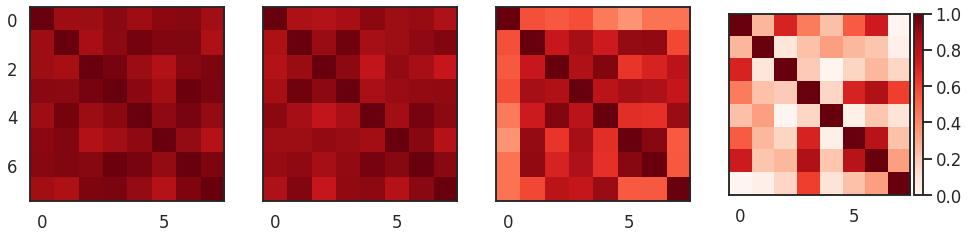

In [98]:
f, axs = plt.subplots(1, 4, figsize=(16,4), sharey=True)

for i in range(4):
    ax = axs[i]
    im = ax.imshow(np.corrcoef(Xs_gcca[:,:,i]), vmin=0, vmax=1, cmap='Reds')

    if i == 3:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

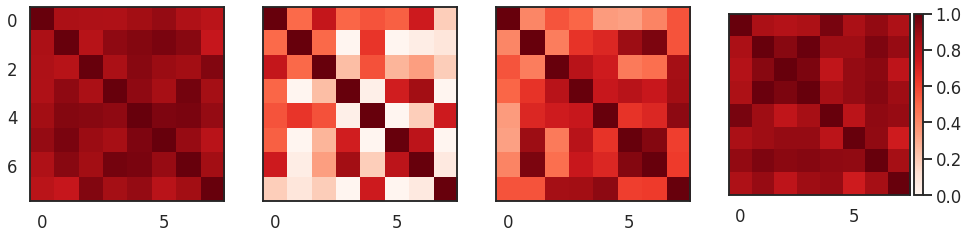

In [99]:
f, axs = plt.subplots(1, 4, figsize=(16,4), sharey=True)

for i in range(4):
    ax = axs[i]
    im = ax.imshow(np.corrcoef(Xs_svds[:,:,i]), vmin=0, vmax=1, cmap='Reds')

    if i == 3:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

## Test align process

## Case 1, 2 subjects w/ 2 scans each
- subject 1: nx2 basis, each scan an orthogonal rotation 
- subject 2: nx3 basis, each scan an orthogonal projection to nx2

In [557]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2']
subjs = [1, 1, 2, 2]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis = ortho_group.rvs(25)
    Xs = [basis[:,:2] @ ortho_group.rvs(2) for _ in range(2)]
    Xs += [basis[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.trace(embs[i].T @ embs[j] / embs.shape[1]) for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.trace(embs[i].T @ embs[j] / embs.shape[1]) for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

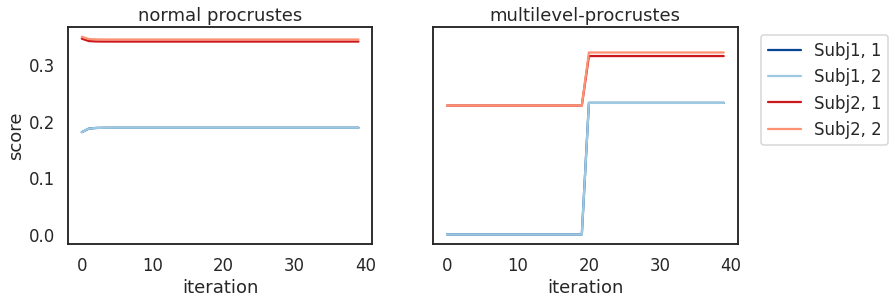

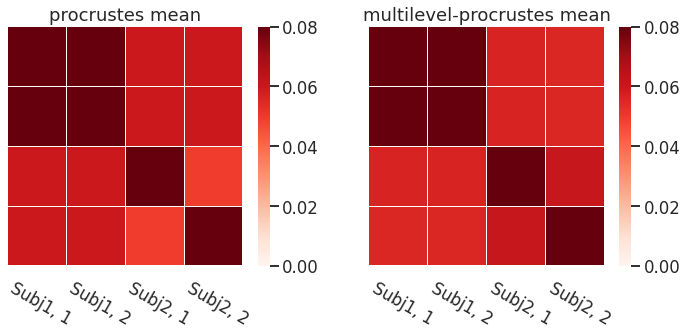

In [558]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = y + objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    # ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1)

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('score')

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = y + objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    # ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1)
    
ax.set_title('multilevel-procrustes')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10,5))
ax = axs[0]
ax = sns.heatmap(
    trace_normal_means, cmap='Reds', vmax=np.max(trace_normal_means), vmin=0, linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')


ax = axs[1]
im = sns.heatmap(
    trace_means, cmap='Reds', vmax=np.max(trace_means), vmin=0, linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

# im = ax.imshow(trace_std, cmap='Reds', vmax=np.max(trace_std), vmin=0)
# ax.set_title('std')
# ax.set_yticklabels([])
# ax.set_xticks([0,1,2,3])
# ax.set_xticklabels(labels, rotation=-30, ha='left')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()

## Case 2: 3 subjects w/ 2 scans each
- each subject: nx3 basis orthogonal projected to nx2

In [590]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis = ortho_group.rvs(25)
    Xs = [basis[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,3:6] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,6:9] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

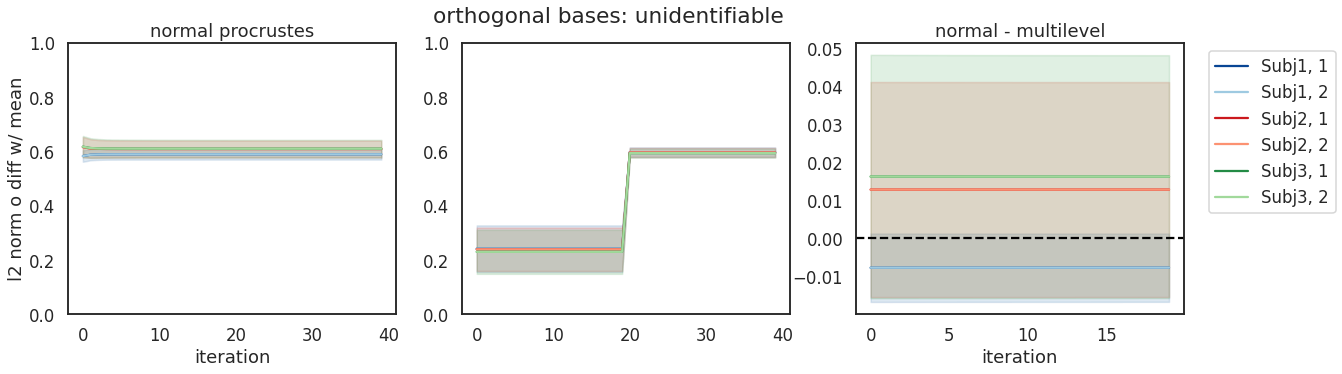

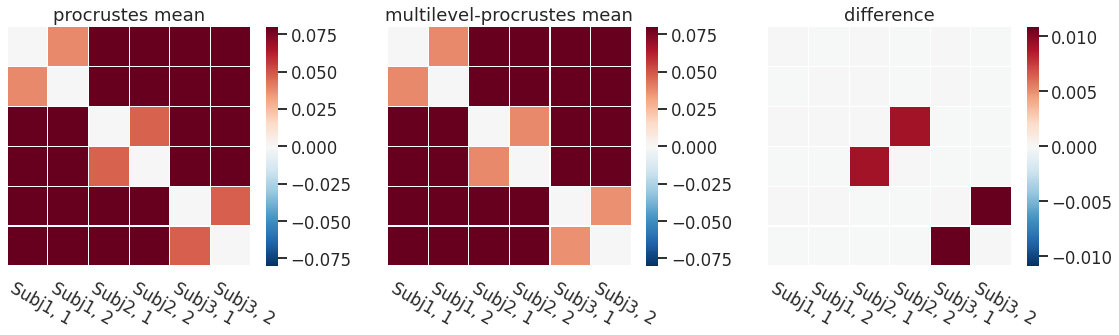

In [592]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('orthogonal bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('normal - multiway')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

# im = ax.imshow(trace_std, cmap='Reds', vmax=np.max(trace_std), vmin=0)
# ax.set_title('std')
# ax.set_yticklabels([])
# ax.set_xticks([0,1,2,3])
# ax.set_xticklabels(labels, rotation=-30, ha='left')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()

In [595]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis = ortho_group.rvs(25)
    Xs = [basis[:,np.asarray([0,1,2])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,np.asarray([0,3,4])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,np.asarray([0,5,6])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs = [X + np.random.normal(0, 0.1, X.shape) for X in Xs]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

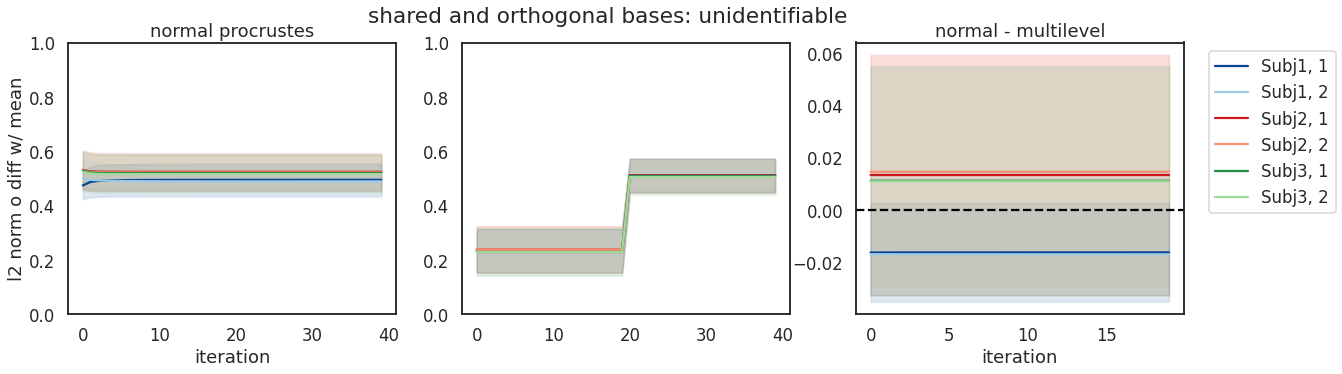

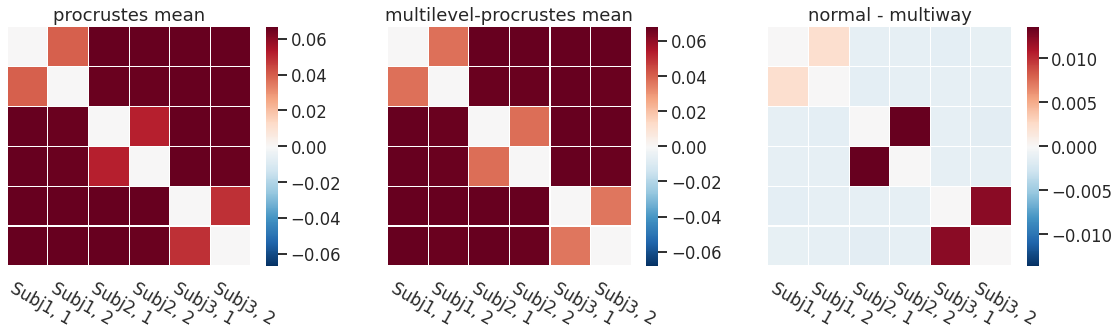

In [596]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('shared and orthogonal bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('normal - multiway')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()

In [102]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis1 = ortho_group.rvs(25)
    basis2 = ortho_group.rvs(25)
    basis3 = ortho_group.rvs(25)
    Xs = [basis1[:,:3] @ ortho_group.rvs(3)[:,:3] for _ in range(2)]
    Xs += [basis2[:,:3] @ ortho_group.rvs(3)[:,:3] for _ in range(2)]
    Xs += [basis3[:,:3] @ ortho_group.rvs(3)[:,:3] for _ in range(2)]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

ValueError: not enough values to unpack (expected 4, got 3)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

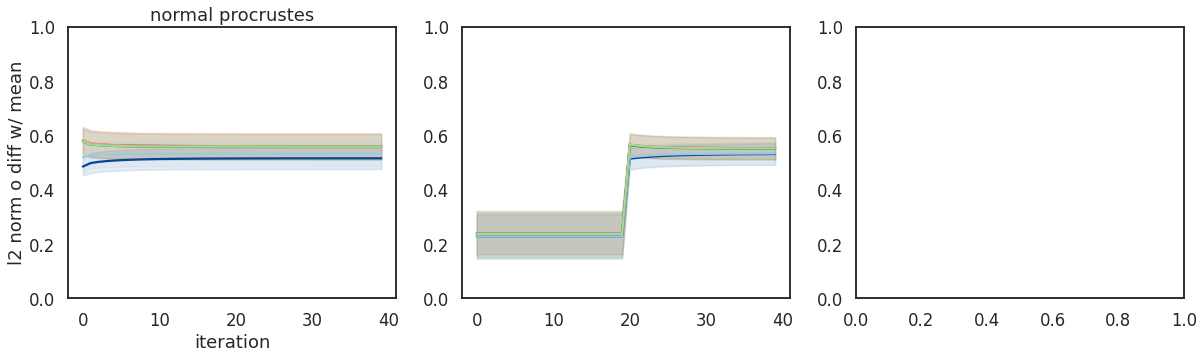

In [104]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Random independent bases: identifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('normal - multiway')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()

In [109]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis1 = ortho_group.rvs(25)
    basis2 = ortho_group.rvs(25)
    basis3 = ortho_group.rvs(25)
    Xs = [basis1[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis2[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis3[:,:3] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    
    obs, embs, _, _= iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False, debug=True
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    obs, embs, _, _= iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align, debug=True
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

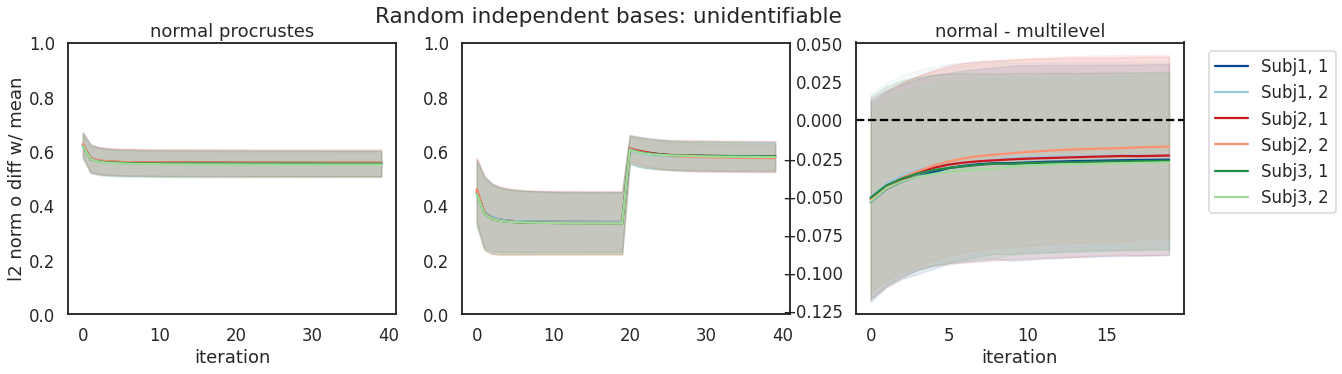

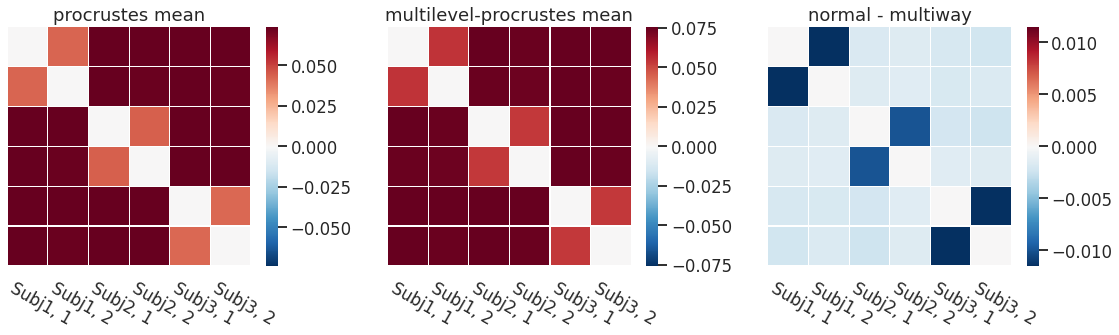

In [107]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Random independent bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('normal - multiway')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()

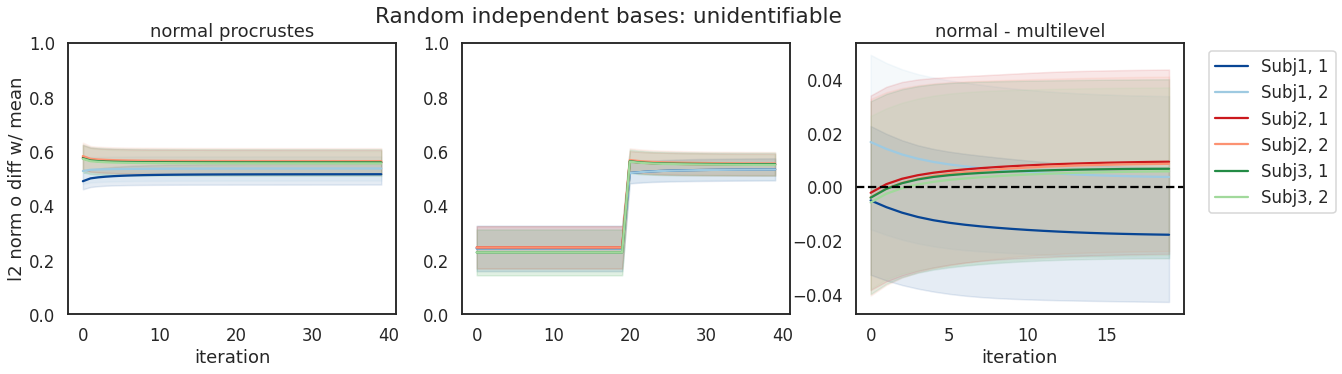

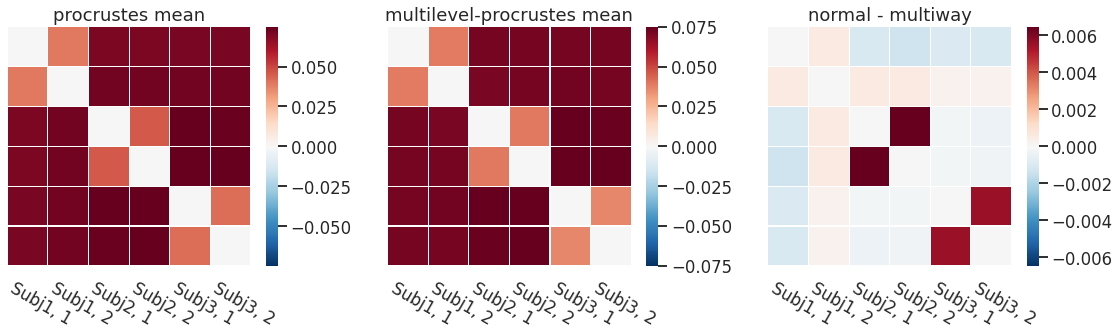

In [110]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Random independent bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('normal - multiway')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()

## Actual alignment data

In [612]:
path = Path('/home/rflperry/meditation/data/DCORR_dmap_antoinne_aligned_normed/')
path = path / 'antoinne_alignment_objs_mean-align=False.csv'
dat = np.genfromtxt(path, delimiter=',', dtype=str)

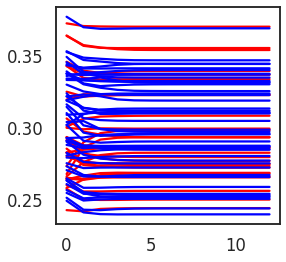

In [617]:
objs = dat[3:].astype(float)
traits = dat[0]
stats = dat[1]
subjs = dat[2]
import matplotlib.pyplot as plt
subj_indices = defaultdict(list)
for i, (subj, trait) in enumerate(zip(subjs, traits)):
    subj_indices[subj].append((i, trait))
f, ax = plt.subplots(1, 1, figsize=(4,4))
iters = np.arange(len(objs))
for subj, items in subj_indices.items():
    label = items[0][1]
    idxs = np.asarray([it[0] for it in items])
    y = np.mean(objs[:, idxs], axis=1)
    ax.plot(iters, y, label=label, color='red' if label=='e' else 'blue')
# plt.legend()
plt.show()

In [618]:
path = Path('/home/rflperry/meditation/data/DCORR_dmap_antoinne_aligned_normed/')
path = path / 'antoinne_alignment_objs_mean-align=False.csv'
dat = np.genfromtxt(path, delimiter=',', dtype=str)

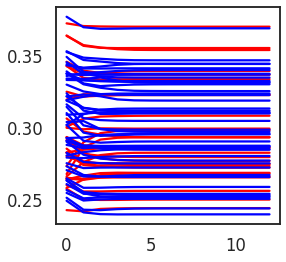

In [619]:
objs = dat[3:].astype(float)
traits = dat[0]
stats = dat[1]
subjs = dat[2]
import matplotlib.pyplot as plt
subj_indices = defaultdict(list)
for i, (subj, trait) in enumerate(zip(subjs, traits)):
    subj_indices[subj].append((i, trait))
f, ax = plt.subplots(1, 1, figsize=(4,4))
iters = np.arange(len(objs))
for subj, items in subj_indices.items():
    label = items[0][1]
    idxs = np.asarray([it[0] for it in items])
    y = np.mean(objs[:, idxs], axis=1)
    ax.plot(iters, y, label=label, color='red' if label=='e' else 'blue')
# plt.legend()
plt.show()

In [624]:
path = Path('/home/rflperry/meditation/data/DCORR_dmap_mapalign_replication_aligned_normed/')
path = path / 'dmap_alignment_objs_mean-align=False.csv'
dat = np.genfromtxt(path, delimiter=',', dtype=str)

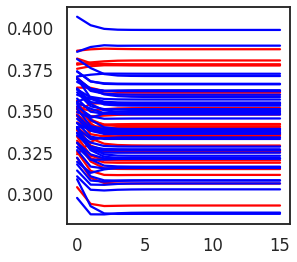

In [625]:
objs = dat[3:].astype(float)
traits = dat[0]
stats = dat[1]
subjs = dat[2]
import matplotlib.pyplot as plt
subj_indices = defaultdict(list)
for i, (subj, trait) in enumerate(zip(subjs, traits)):
    subj_indices[subj].append((i, trait))
f, ax = plt.subplots(1, 1, figsize=(4,4))
iters = np.arange(len(objs))
for subj, items in subj_indices.items():
    label = items[0][1]
    idxs = np.asarray([it[0] for it in items])
    y = np.mean(objs[:, idxs], axis=1)
    ax.plot(iters, y, label=label, color='red' if label=='e' else 'blue')
# plt.legend()
plt.show()

In [641]:
path = Path('/home/rflperry/meditation/data/DCORR_svd_raw_aligned_normed/')
path = path / 'svd_alignment_objs_mean-align=False.csv'
dat = np.genfromtxt(path, delimiter=',', dtype=str)

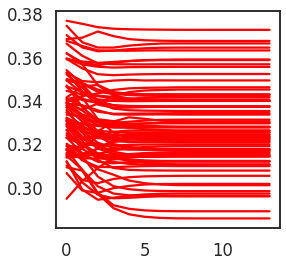

In [649]:
objs = dat[3:].astype(float)
traits = dat[0]
states = dat[1]
subjs = dat[2]
import matplotlib.pyplot as plt
subj_indices = defaultdict(list)
for i, (subj, trait, state) in enumerate(zip(subjs, traits, states)):
    subj_indices[subj].append((i, trait, state))
f, ax = plt.subplots(1, 1, figsize=(4,4))
iters = np.arange(len(objs))
for subj, items in subj_indices.items():
    label = items[0][2]
    idxs = np.asarray([it[0] for it in items])
    y = np.mean(objs[:, idxs], axis=1)
    ax.plot(iters, y, label=label, color='red' if label=='restingstate' else 'green' if label=='compassion' else 'blue')
# plt.legend()
plt.show()

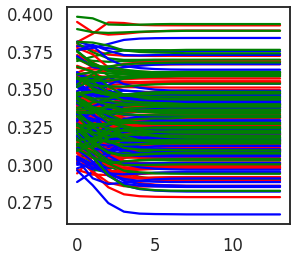

In [650]:
objs = dat[3:].astype(float)
traits = dat[0]
states = dat[1]
subjs = dat[2]
import matplotlib.pyplot as plt
subj_indices = defaultdict(list)
f, ax = plt.subplots(1, 1, figsize=(4,4))
iters = np.arange(len(objs))
for i, label in enumerate(states):
    y = objs[:, i]
    ax.plot(iters, y, label=label, color='red' if label=='restingstate' else 'green' if label=='compassion' else 'blue')
# plt.legend()
plt.show()

In [15]:
labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 40
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 250
trace_mats = []
objs = []
objs_normal = []
trace_normal = []

for _ in range(reps):
    basis = ortho_group.rvs(25)
    Xs = [basis[:,np.asarray([0,1,2])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,np.asarray([3,4,5])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    Xs += [basis[:,np.asarray([6,7,8])] @ ortho_group.rvs(3)[:,:2] for _ in range(2)]
    # Xs = [X + np.random.normal(0, 0.1, X.shape) for X in Xs]
    
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False
    )
    objs_normal.append(obs)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
        
    embs, _, _, obs = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align
    )
    objs.append(obs)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

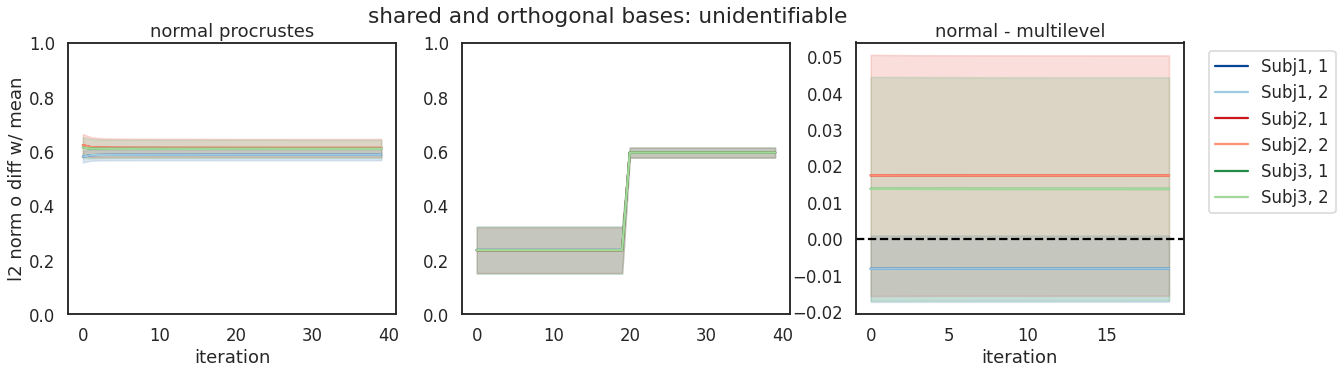

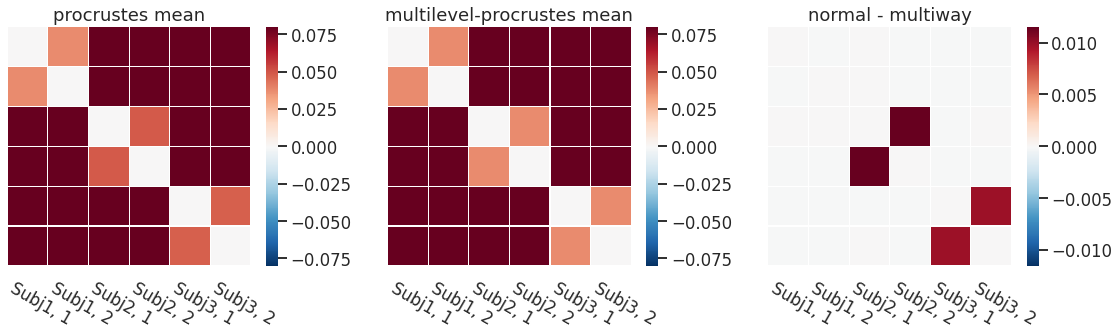

In [16]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    ax.plot(iters, y, label=labels[i], c=colors[i])
    ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('shared and orthogonal bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.1, ax=ax)
ax.set_title('normal - multiway')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()

In [2]:
n_subjs = 30
n = 200
labels = np.hstack([[f'Subj{i}, 1', f'Subj{i}, 2'] for i in range(n_subjs)])
# labels = ['Subj1, 1', 'Subj1, 2', 'Subj2, 1', 'Subj2, 2', 'Subj3, 1', 'Subj3, 2']
# subjs = [1, 1, 2, 2, 3, 3]
thresh = 0
max_iter = 20
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 100
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []

for _ in range(reps):
    Xs, labels, subjs = two_samp_bases(
        n_subjs=n_subjs, n=n, d_shared=2, d_indiv=2, n_shared_bases=3, n_indiv_bases=3, epsilon=0, per_subj=2)
    obs, embs, _, _ = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False, debug=True
    )
    objs_normal.append(obs)
    embs = np.asarray(embs)
#     tmp = []
#     for i in range(embs.shape[-1]):
#         stat, pvalue = Dcorr().test(embs[:, :, i], labels, perm_blocks=subjs)
#         tmp.append(pvalue)
#     pvals_normal.append(tmp)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
    embs_normal = embs
        
    obs, embs, _, _ = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align, debug=True
    )
    objs.append(obs)
#     embs = np.asarray(embs)
#     tmp = []
#     for i in range(embs.shape[-1]):
#         stat, pvalue = Dcorr().test(embs[:, :, i], labels, perm_blocks=subjs)
#         tmp.append(pvalue)
#     pvals_normal.append(tmp)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

pvals = np.asarray(pvals)
pvals_normal = np.asarray(pvals_normal)

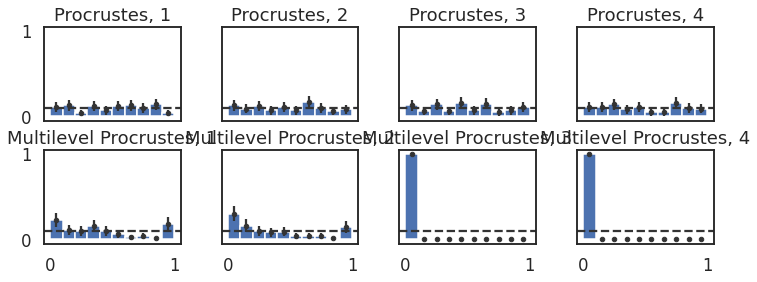

In [153]:
f, axs = plt.subplots(2,4,sharey=True,sharex=True, figsize=(12,4))
tests = np.asarray([pvals_normal, pvals])
names = ['Procrustes', 'Multilevel Procrustes']
for r in range(2):
    name = names[r]
    for c in range(4):
        test = tests[r, :, c]
        ax = axs[r, c]
        n = len(test)
        entries, edges, _ = ax.hist(test, bins = np.arange(0,1.1,0.1), weights=np.ones(n)/n, color='b')
        # entries = height of each column = proportion in that bin
        # calculate bin centers
        bin_centers = 0.5 * (edges[:-1] + edges[1:])
        ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
        # errorbars are binomial proportion confidence intervals
        ax.errorbar(
            bin_centers, entries,
            yerr = 1.96 * np.sqrt(entries * (1 - entries) / n),
            fmt='.',c='#333333'
        )
        ax.set_title(f'{name}, {c+1}')
        #ax.set_xlim(0,1)
        if r == 0:
            ax.set_xticks([])
        else:
            ax.set_xticks([0,1])
        if c == 0:
            ax.set_xticks([0, 0.1, 1])
        else:
            ax.set_xticks([0,1])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

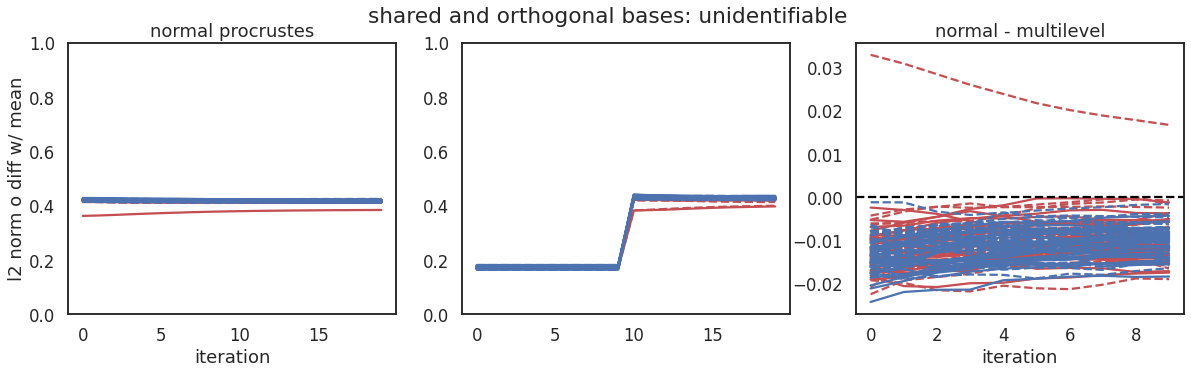

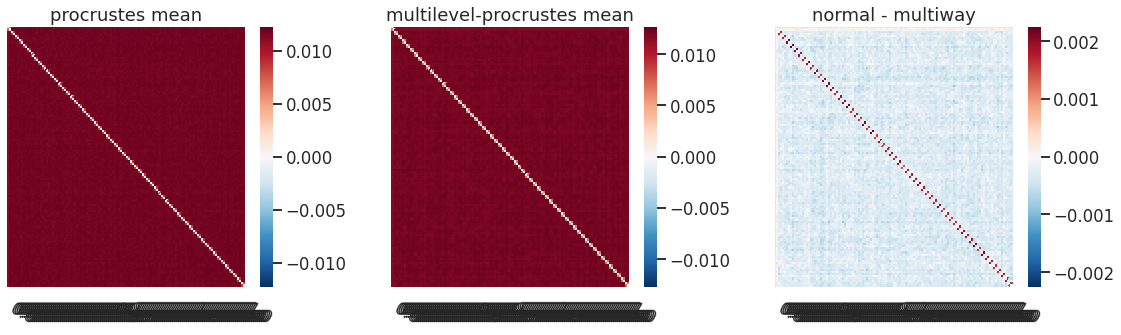

In [3]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    if i % 2 == 0:
        ls = '-'
    else:
        ls = '--'
    ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
    # ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    if i % 2 == 0:
        ls = '-'
    else:
        ls = '--'
    ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    if i % 2 == 0:
        ls = '-'
    else:
        ls = '--'
    ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('shared and orthogonal bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
ax.set_title('normal - multiway')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()

## independent bases: dcorr

In [170]:
n_subjs = 30
n = 200
thresh = 0
max_iter = 20
mean_align = True
if mean_align:
    max_iter = int(max_iter / 2)

reps = 100
trace_mats = []
objs = []
objs_normal = []
trace_normal = []
pvals = []
pvals_normal = []

for _ in range(reps):
    Xs = np.vstack([[
        ortho_group.rvs(n)[:,:6] @ ortho_group.rvs(6)[:,:4] for _ in range(2)
    ] for _ in range(n_subjs*2)])
    subjs = np.hstack([[i]*2 for i in range(2*n_subjs)])
    labels = np.hstack([np.zeros(2*n_subjs), np.ones(2*n_subjs)])
    
    obs, embs, _, _ = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=int(max_iter*2), norm=False, mean_align=False, debug=True
    )
    objs_normal.append(obs)
    embs = np.asarray(embs)
    tmp = []
    for i in range(embs.shape[-1]):
        stat, pvalue = Dcorr().test(embs[:, :, i], labels, perm_blocks=subjs)
        tmp.append(pvalue)
    pvals.append(tmp)
    
    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_normal.append(np.asarray(trace_mat))
    embs_normal = embs
        
    obs, embs, _, _ = iterate_align(
        Xs, labels, subjs, thresh=thresh, max_iter=max_iter, norm=False, mean_align=mean_align, debug=True
    )
    objs.append(obs)
    embs = np.asarray(embs)
    tmp = []
    for i in range(embs.shape[-1]):
        stat, pvalue = Dcorr().test(embs[:, :, i], labels, perm_blocks=subjs)
        tmp.append(pvalue)
    pvals_normal.append(tmp)

    trace_mat = [
        [np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for j in range(embs.shape[0])] for i in range(embs.shape[0])
    ]
    trace_mats.append(np.asarray(trace_mat))
    
trace_means = np.mean(trace_mats, axis=0)
trace_std = np.std(trace_mats, axis=0)
objs_means = np.mean(objs, axis=0)
objs_std = np.std(objs, axis=0)

trace_normal_means = np.mean(trace_normal, axis=0)
trace_normal_std = np.std(trace_normal, axis=0)
objs_normal_means = np.mean(objs_normal, axis=0)
objs_normal_std = np.std(objs_normal, axis=0)

pvals = np.asarray(pvals)
pvals_normal = np.asarray(pvals_normal)


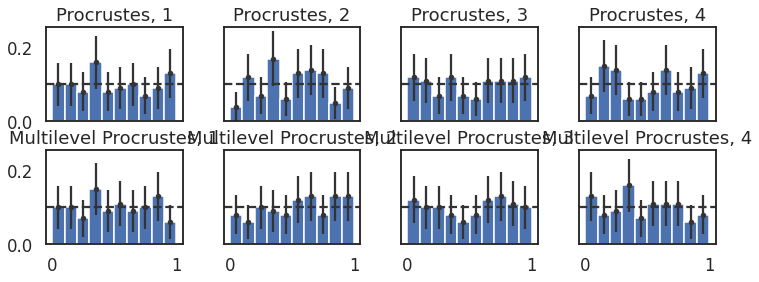

In [171]:
f, axs = plt.subplots(2,4,sharey=True,sharex=True, figsize=(12,4))
tests = np.asarray([pvals_normal, pvals])
names = ['Procrustes', 'Multilevel Procrustes']
for r in range(2):
    name = names[r]
    for c in range(4):
        test = tests[r, :, c]
        ax = axs[r, c]
        n = len(test)
        entries, edges, _ = ax.hist(test, bins = np.arange(0,1.1,0.1), weights=np.ones(n)/n, color='b')
        # entries = height of each column = proportion in that bin
        # calculate bin centers
        bin_centers = 0.5 * (edges[:-1] + edges[1:])
        ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
        # errorbars are binomial proportion confidence intervals
        ax.errorbar(
            bin_centers, entries,
            yerr = 1.96 * np.sqrt(entries * (1 - entries) / n),
            fmt='.',c='#333333'
        )
        ax.set_title(f'{name}, {c+1}')
        #ax.set_xlim(0,1)
        if r == 0:
            ax.set_xticks([])
        else:
            ax.set_xticks([0,1])
        if c == 0:
            ax.set_xticks([0, 0.1, 1])
        else:
            ax.set_xticks([0,1])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

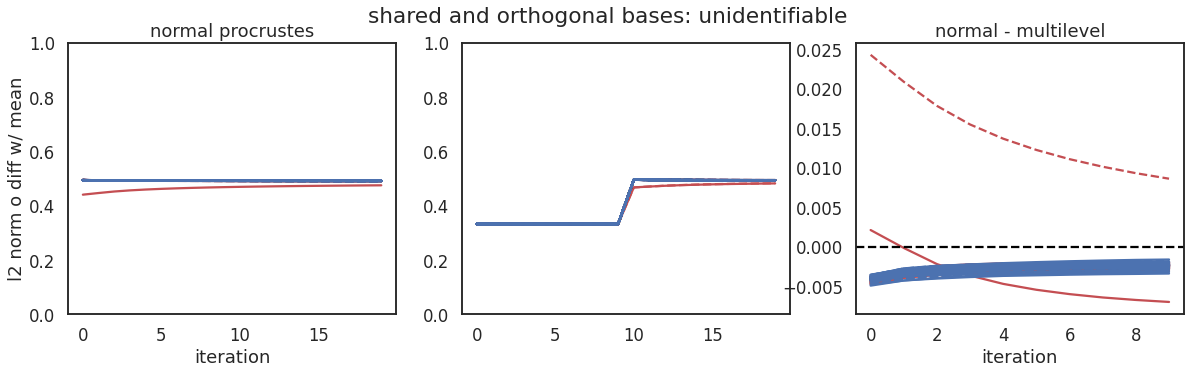

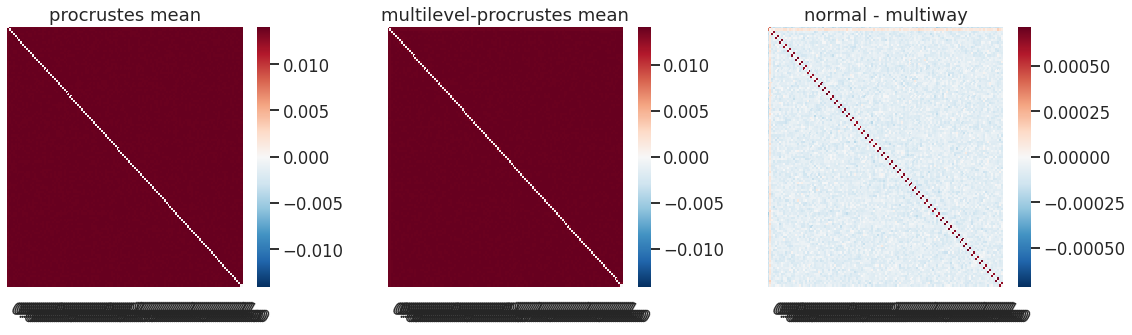

In [172]:
colors = ['#084594', '#9ecae1', '#cb181d', '#fc9272', '#238b45', '#a1d99b']
f, axs = plt.subplots(1, 3, figsize=(20,5), sharey=False)
iters = np.arange(objs_means.shape[0])

ax = axs[0]
for i in range(objs_means.shape[1]):
    y = objs_normal_means[:, i]
    yerr = objs_normal_std[:, i]
    if i % 2 == 0:
        ls = '-'
    else:
        ls = '--'
    ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
    # ax.fill_between(iters, (y-yerr), (y+yerr), alpha=.1, color=colors[i])

ax.set_title('normal procrustes')
ax.set_xlabel('iteration')
ax.set_ylabel('l2 norm o diff w/ mean')
ax.set_ylim(0,1)

ax = axs[1]
for i in range(objs_means.shape[1]):
    y = objs_means[:, i]
    yerr = objs_std[:, i]
    if i % 2 == 0:
        ls = '-'
    else:
        ls = '--'
    ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
ax.set_ylim(0,1)

    
ax = axs[2]
diff = np.asarray(objs_normal)[:, max_iter:, :] - np.asarray(objs)[:, max_iter:, :]
iters = np.arange(max_iter)
for i in range(objs_means.shape[1]):
    y = np.mean(diff[:,:,i], axis=0)
    yerr = np.std(diff[:,:,i], axis=0)
    if i % 2 == 0:
        ls = '-'
    else:
        ls = '--'
    ax.plot(iters, y, label=labels[i], ls=ls, c='r' if labels[i]==0 else 'b')
ax.axhline(0, ls='--', c='black')
    
ax.set_title('normal - multilevel')
ax.set_xlabel('iteration')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('shared and orthogonal bases: unidentifiable')
plt.show()

############### Heatmap ###############

fig, axs = plt.subplots(1, 3, figsize=(16,5))
ax = axs[0]
mat = trace_normal_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
ax.set_title('procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[1]
mat = trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
ax.set_title('multilevel-procrustes mean')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

ax = axs[2]
mat = trace_normal_means - trace_means
ax = sns.heatmap(
    mat, cmap='RdBu_r', vmax=np.max(np.abs(mat)), vmin=-np.max(np.abs(mat)), linewidth=0.0, ax=ax)
ax.set_title('normal - multiway')
ax.set_yticklabels([])
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-30, ha='left')

fig.tight_layout()
plt.show()